In [33]:
# Reference: https://github.com/lightsalsa251/Diabetic-Retinopathy-with-CNN/blob/master/Model_script.ipynb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory|

Data Loading

In [34]:
# Loading test and training target dataset
base_dir = "G:/Mon Drive/"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
im_size = 320
im_size1 = im_size
im_size2 = im_size

def append_ext(fn):
    return fn+".jpg"

df_train = pd.read_csv(base_dir + "dataset/dbfinal_train_NOupsample.csv", dtype=str)
df_train.head() 
#df_train.level = df_train.level.to_string()
df_train["img_name"]=df_train["img_name"].apply(append_ext)

datagen = ImageDataGenerator(horizontal_flip=True, 
                            zoom_range=[0.80,1])
train_ds = datagen.flow_from_dataframe(dataframe=df_train,
    directory=base_dir+'dataset/train/denoiseCLAHE/',
    x_col='img_name',
    y_col="level",
    batch_size=32,
    seed=2022,
    shuffle=True,
    class_mode="categorical",
    target_size=(im_size, im_size2)) 

 
df_val = pd.read_csv(base_dir + "dataset/dbfinal_test_NOupsample.csv", dtype=str)
df_val["level"] = df_val["level"].astype(str)
df_val["img_name"]=df_val["img_name"].apply(append_ext)

datagen = ImageDataGenerator()
val_ds = datagen.flow_from_dataframe(dataframe=df_val,
    directory=base_dir+'dataset/train/denoiseCLAHE/',
    x_col='img_name',
    y_col="level",
    batch_size=32,
    seed=2022,
    shuffle=True,
    class_mode="categorical",
    target_size=(im_size, im_size2)) 

Found 17582 validated image filenames belonging to 5 classes.
Found 4394 validated image filenames belonging to 5 classes.


g:\Mon Drive\8. PhD\7. Codes\Py373\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


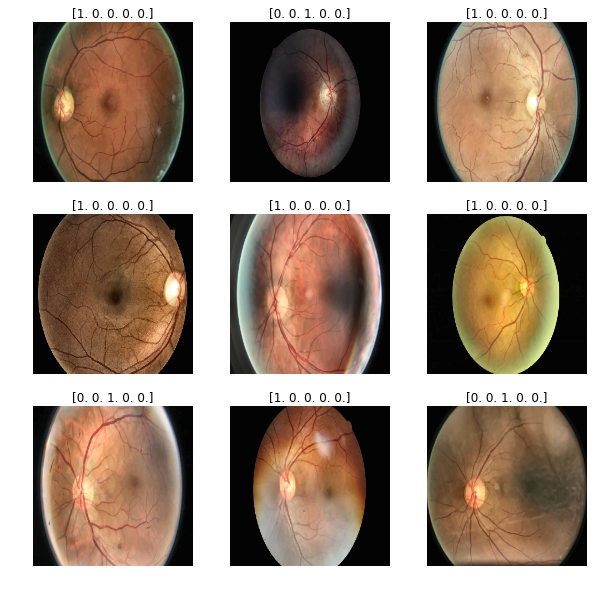

In [36]:
# Observamos un grupo de estas fotos:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  label = label_batch[i]
  plt.title(label)
  plt.axis("off")

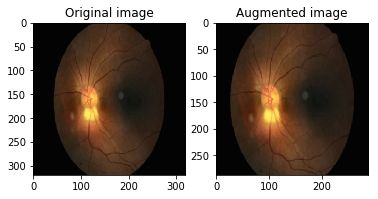

In [39]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original.astype("uint8"))

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented.numpy().astype("uint8"))
  
image_batch, label = next(iter(train_ds))
i = 1
cropped = tf.image.central_crop(image_batch[i], central_fraction=0.9)
visualize(image_batch[1], cropped)

## Model

In [40]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy


class WeightedCategoricalCrossentropy(CategoricalCrossentropy):

    def __init__(self, cost_mat=np.ones((5, 5)), name='weighted_categorical_crossentropy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])

        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)

    def __call__(self, y_true, y_pred, sample_weight=None):

        return super().__call__(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )
        
    def get_config(self):
        return super().get_config().copy().update(
            {'cost_mat': self.cost_mat}
        )
    #def get_config(self):
    #    return {'cost_mat': self.cost_mat}
        
    @classmethod
    def from_config(cls, config):
       return cls(**config)


def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Categorical accuracy:
from tensorflow.keras.metrics import CategoricalAccuracy


class WeightedCategoricalAccuracy(CategoricalAccuracy):

    def __init__(self, cost_mat=np.ones((5, 5)), name='weighted_categorical_accuracy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])

        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)

    def update_state(self, y_true, y_pred, sample_weight=None):

        return super().update_state(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )
#
# model.compile(metrics=[WeightedCategoricalAccuracy(cost_matrix), ...], ...)

# Matriz de costos: 
import numpy as np
w_array = np.ones((5, 5))
# If >1 - it penalize Class i classified as j
i = 0
j = 1 
w_array[i, j] = 1
# Overall enphasis in class i:
w_array[1, :] = 10 #10
w_array[2, :] = 5 #5
w_array[3, :] = 10 #29
w_array[4, :] = 10 #37
cost_mat = w_array
cost_mat


array([[ 1.,  1.,  1.,  1.,  1.],
       [10., 10., 10., 10., 10.],
       [ 5.,  5.,  5.,  5.,  5.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.]])

In [41]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath=base_dir + 'models/PretrainedNetworks/EfficientNetB3_v3_im'+ str(im_size) +'.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=base_dir + 'models/PretrainedNetworks/logs_EfficientNetB3_v3_im'+ str(im_size) ),
]

In [49]:
from tensorflow.keras.applications import EfficientNetB3
import tensorflow_addons as tfa
base_model1 = EfficientNetB3(weights = 'imagenet', include_top=False, input_shape=(im_size1, im_size2, 3))

num_class = 5

# Add a new top layer
x = base_model1.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model1 = Model(inputs=base_model1.input, outputs=predictions)

print(model1.layers[1])
print(model1.layers[1].scale)  #0.003=1/255

# First: train only top layers
for layer in base_model1.layers:
    layer.trainable = False
    
# [f.trainable for f in model1.layers]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-4,
                decay_steps=5000,
                decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(loss=tfa.losses.WeightedKappaLoss(num_classes=5, weightage="quadratic"), 
              optimizer = opt, 
              metrics=WeightedCategoricalAccuracy(cost_mat)) 


0.00392156862745098


In [50]:
# First round:
history1_model1 = model1.fit(train_ds, epochs=30, validation_data= val_ds, verbose=1, batch_size=64, callbacks=my_callbacks)

Epoch 1/30
550/550 [==============================] - 3379s 6s/step - loss: -0.0245 - weighted_categorical_accuracy: 0.2330 - val_loss: -0.0803 - val_weighted_categorical_accuracy: 0.2327
Epoch 2/30
550/550 [==============================] - 3215s 6s/step - loss: -0.1149 - weighted_categorical_accuracy: 0.2630 - val_loss: -0.2407 - val_weighted_categorical_accuracy: 0.3025
Epoch 3/30
550/550 [==============================] - 2140s 4s/step - loss: -0.2717 - weighted_categorical_accuracy: 0.3079 - val_loss: -0.3976 - val_weighted_categorical_accuracy: 0.3138
Epoch 4/30
550/550 [==============================] - 2121s 4s/step - loss: -0.3404 - weighted_categorical_accuracy: 0.3115 - val_loss: -0.4182 - val_weighted_categorical_accuracy: 0.3138
Epoch 5/30
550/550 [==============================] - 2218s 4s/step - loss: -0.3879 - weighted_categorical_accuracy: 0.3148 - val_loss: -0.4260 - val_weighted_categorical_accuracy: 0.3161
Epoch 6/30
550/550 [==============================] - 2491s 

dict_keys(['loss', 'weighted_categorical_accuracy', 'val_loss', 'val_weighted_categorical_accuracy'])


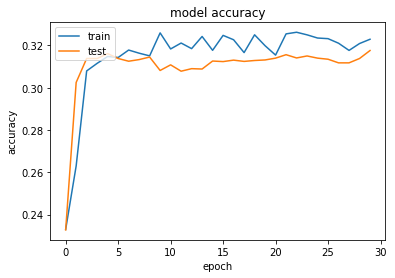

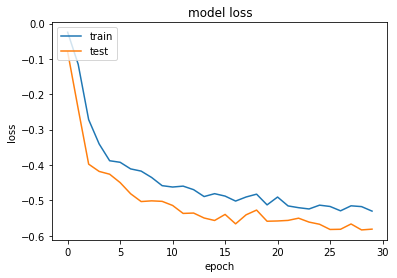

In [52]:
import matplotlib.pyplot as plt
history = history1_model1
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['weighted_categorical_accuracy'])
plt.plot(history.history['val_weighted_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
df_init = {
    'loss': [0.0],
    'weighted_categorical_accuracy': [0.0],
    'val_loss': [0.0], 
    'val_weighted_categorical_accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

dic = history.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB3_v3_im'+ str(im_size) + '.csv' )

In [54]:
# Second round:
Hresults = model1.fit(train_ds, epochs=60, initial_epoch=30, validation_data= val_ds, verbose=1, batch_size=64, callbacks=my_callbacks)
dic = Hresults.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB3_v3_im'+ str(im_size) + '.csv' )

Epoch 31/60
550/550 [==============================] - 2684s 5s/step - loss: -0.5281 - weighted_categorical_accuracy: 0.3268 - val_loss: -0.5640 - val_weighted_categorical_accuracy: 0.3177
Epoch 32/60
550/550 [==============================] - 2375s 4s/step - loss: -0.5212 - weighted_categorical_accuracy: 0.3255 - val_loss: -0.5982 - val_weighted_categorical_accuracy: 0.3153
Epoch 33/60
550/550 [==============================] - 2376s 4s/step - loss: -0.5222 - weighted_categorical_accuracy: 0.3202 - val_loss: -0.5960 - val_weighted_categorical_accuracy: 0.3165
Epoch 34/60
550/550 [==============================] - 2374s 4s/step - loss: -0.5278 - weighted_categorical_accuracy: 0.3192 - val_loss: -0.5904 - val_weighted_categorical_accuracy: 0.3181
Epoch 35/60
550/550 [==============================] - 2369s 4s/step - loss: -0.5337 - weighted_categorical_accuracy: 0.3231 - val_loss: -0.6015 - val_weighted_categorical_accuracy: 0.3195
Epoch 36/60
550/550 [==============================] - 

In [55]:
# Second round:
Hresults = model1.fit(train_ds, epochs=80, initial_epoch=60, validation_data= val_ds, verbose=1, batch_size=32, callbacks=my_callbacks)
dic = Hresults.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB3_v3_im'+ str(im_size) + '.csv' )

Epoch 61/80
550/550 [==============================] - 2120s 4s/step - loss: -0.5552 - weighted_categorical_accuracy: 0.3301 - val_loss: -0.6220 - val_weighted_categorical_accuracy: 0.3217
Epoch 62/80
550/550 [==============================] - 2120s 4s/step - loss: -0.5433 - weighted_categorical_accuracy: 0.3340 - val_loss: -0.6204 - val_weighted_categorical_accuracy: 0.3199
Epoch 63/80
550/550 [==============================] - 2116s 4s/step - loss: -0.5477 - weighted_categorical_accuracy: 0.3285 - val_loss: -0.5962 - val_weighted_categorical_accuracy: 0.3181
Epoch 64/80
550/550 [==============================] - 2118s 4s/step - loss: -0.5437 - weighted_categorical_accuracy: 0.3247 - val_loss: -0.6206 - val_weighted_categorical_accuracy: 0.3234
Epoch 65/80
550/550 [==============================] - 2113s 4s/step - loss: -0.5440 - weighted_categorical_accuracy: 0.3203 - val_loss: -0.6129 - val_weighted_categorical_accuracy: 0.3225
Epoch 66/80
550/550 [==============================] - 

dict_keys(['loss', 'weighted_categorical_accuracy', 'val_loss', 'val_weighted_categorical_accuracy'])


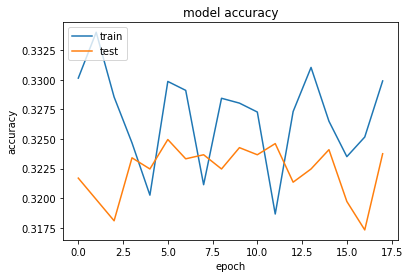

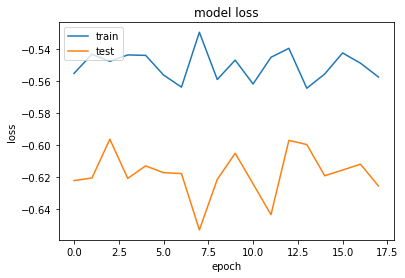

In [57]:
import matplotlib.pyplot as plt
history = Hresults
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['weighted_categorical_accuracy'])
plt.plot(history.history['val_weighted_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
# Last round
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-6,
                decay_steps=5000,
                decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(loss=tfa.losses.WeightedKappaLoss(num_classes=5, weightage="quadratic"), 
              optimizer = opt, 
              metrics=WeightedCategoricalAccuracy(cost_mat)) 

i=9
Hresults = model1.fit(train_ds, epochs=85, initial_epoch=80, steps_per_epoch=50,validation_data= val_ds, verbose=1, batch_size=32, callbacks=my_callbacks)
dic = Hresults.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB3_v3_im'+ str(im_size) + '.csv' )

g:\Mon Drive\8. PhD\7. Codes\Py373\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 81/85
50/50 [==============================] - 680s 14s/step - loss: -0.6407 - weighted_categorical_accuracy: 0.3629 - val_loss: -0.6174 - val_weighted_categorical_accuracy: 0.3237
Epoch 82/85
50/50 [==============================] - 634s 13s/step - loss: -0.5605 - weighted_categorical_accuracy: 0.3318 - val_loss: -0.6551 - val_weighted_categorical_accuracy: 0.3243
Epoch 83/85
50/50 [==============================] - 638s 13s/step - loss: -0.5511 - weighted_categorical_accuracy: 0.3637 - val_loss: -0.6033 - val_weighted_categorical_accuracy: 0.3249
Epoch 84/85
50/50 [==============================] - 914s 19s/step - loss: -0.5699 - weighted_categorical_accuracy: 0.3317 - val_loss: -0.6359 - val_weighted_categorical_accuracy: 0.3237
Epoch 85/85
50/50 [==============================] - 632s 13s/step - loss: -0.6079 - weighted_categorical_accuracy: 0.3501 - val_loss: -0.6201 - val_weighted_categorical_accuracy: 0.3222


dict_keys(['loss', 'weighted_categorical_accuracy', 'val_loss', 'val_weighted_categorical_accuracy'])


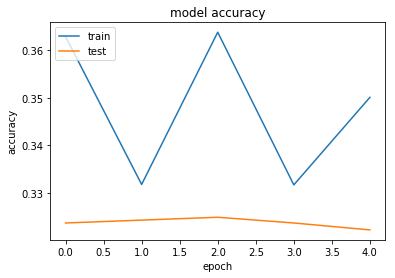

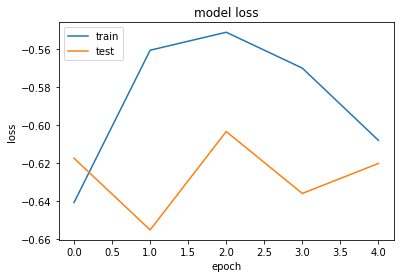

In [60]:
import matplotlib.pyplot as plt
history = Hresults
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['weighted_categorical_accuracy'])
plt.plot(history.history['val_weighted_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()